<a href="https://colab.research.google.com/github/YonggunJung/ICT_TensorFlow/blob/main/20230926.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 압축 풀기
!unzip cat_dog_small.zip

Archive:  cat_dog_small.zip
   creating: test/
   creating: test/cats/
  inflating: test/cats/cat.1500.jpg  
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(20, 150, 150, 3)
(20,)


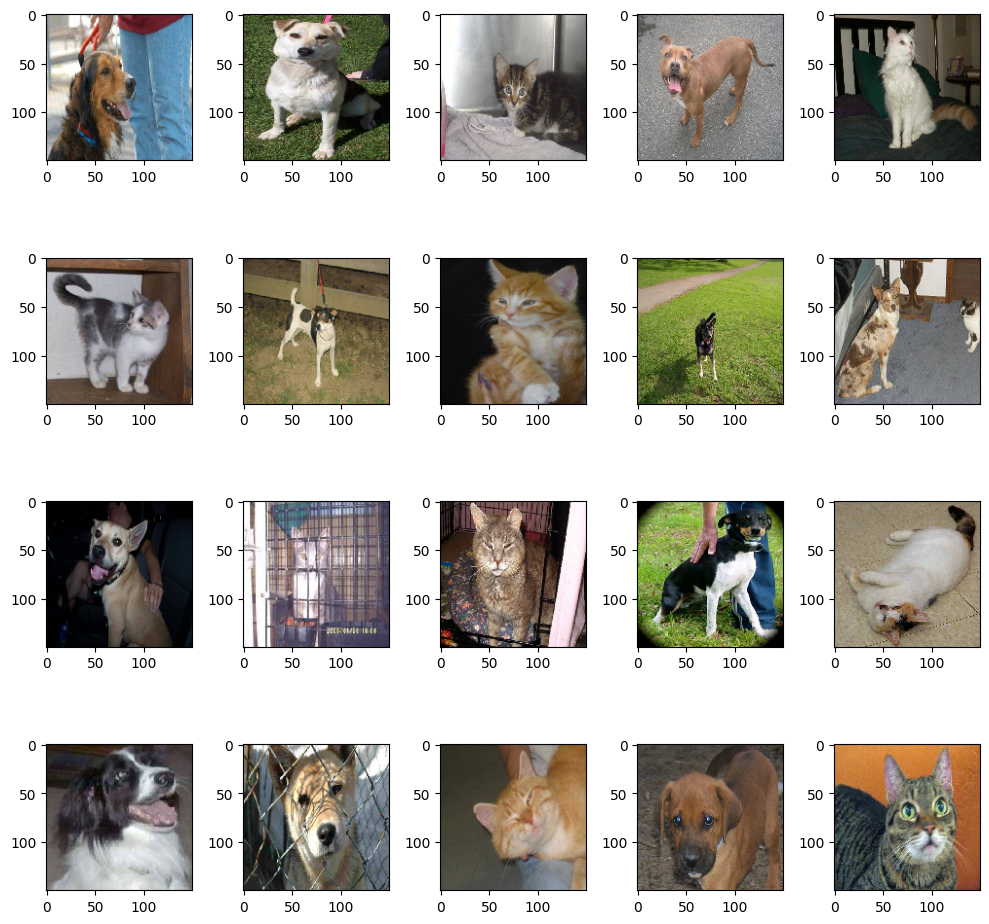

In [4]:
# ImageDataGenerator을 이용해서
# Kaggle의 Dogs vs Cats 전체 이미지를 학습하고 평가

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# ImageDataGenerator 생성

# 모든 이미지 데이터값을 1/255로 scaling(MinMaxScaling)하는
# ImageDataGenerator 생성

train_data_generator = ImageDataGenerator(rescale = 1/255)
validation_data_generator = ImageDataGenerator(rescale = 1/255)

train_dir = '/content/train'
validation_dir = '/content/validation'

# 실제 데이터를 추출하는 generator 생성
train_generator = train_data_generator.flow_from_directory(
    train_dir, # target directory
    classes = ['cats', 'dogs'],  # cats, dogs 폴더 순서로 0,1로 target을 지정
    target_size = (150, 150), # image resize
    batch_size = 20,
    class_mode = 'binary' # 만약 다중분류일 경우라면 categorical
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir, # target directory
    classes = ['cats', 'dogs'],  # cats, dogs 폴더 순서로 0,1로 target을 지정
    target_size = (150, 150), # image resize
    batch_size = 20,
    class_mode = 'binary' # 만약 다중분류일 경우라면 categorical
)

# 이렇게 만든 generator가 정상적으로 동작하는지 확인
for x_data, t_data in train_generator:
    print(x_data.shape)
    print(t_data.shape)
    break

# 그림을 이용해서 추출한 데이터가 이미지 데이터인지 확인
fig = plt.figure(figsize = (10,10))
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4, 5, i+1))

for x_data, t_data in train_generator:

    for idx, img_data in enumerate(x_data): # (20, 150, 150, 3)
        axs[idx].imshow(img_data)
    break

fig.tight_layout()
plt.show()

In [5]:
# 위에서 생성한 ImageDataGenerator를 이용해서 keras model을 생성해서 학습
# CNN 구현
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()

# 1
model.add(Conv2D(filters = 32,
                kernel_size = (3,3),
                activation = 'relu',
                input_shape = (150, 150, 3)))

model.add(MaxPooling2D(pool_size = (2, 2)))
# 2
model.add(Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
# 3
model.add(Conv2D(filters = 128,
                kernel_size = (3,3),
                activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
# 4
model.add(Conv2D(filters = 128,
                kernel_size = (3,3),
                activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))  # 특성추출 끝

model.add(Flatten())

model.add(Dropout(rate = 0.5))

model.add(Dense(units = 256,
               activation = 'relu'))

model.add(Dense(units = 1,
               activation = 'sigmoid'))

model.summary()

# Total params: 1,846,977
# Trainable params: 1,846,977
# Non-trainable params: 0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [12]:
model.compile(optimizer = Adam(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# train_generator는 한번에 이미지 데이터를 20장 뽑는다
# 그런데 1 epoch을 수행 하려면 14,000개 이미지 사용
# 따라서 1 epoch을 돌리기 위해 generator는 700번 수행
model_result = model.fit(train_generator,
                         steps_per_epoch = 100,
                         epochs = 30,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 20s 67ms/step - loss: 0.6862 - accuracy: 0.5435 - val_loss: 0.6893 - val_accuracy: 0.5390
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6674 - accuracy: 0.5845 - val_loss: 0.6675 - val_accuracy: 0.5630
Epoch 3/30
100/100 [==============================] - 5s 54ms/step - loss: 0.6402 - accuracy: 0.6140 - val_loss: 0.6280 - val_accuracy: 0.6360
Epoch 4/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5998 - accuracy: 0.6725 - val_loss: 0.6116 - val_accuracy: 0.6720
Epoch 5/30
100/100 [==============================] - 7s 65ms/step - loss: 0.5686 - accuracy: 0.7025 - val_loss: 0.6119 - val_accuracy: 0.6510
Epoch 6/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5313 - accuracy: 0.7375 - val_loss: 0.5758 - val_accuracy: 0.6910
Epoch 7/30
100/100 [==============================] - 7s 66ms/step - loss: 0.5048 - accuracy: 0.7475 - val_loss: 0.5706 - val_accuracy: 0.701

<ipython-input-14-d825deb58ac0>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(train_acc, 'bo', color='r', label='training accuracy')
<ipython-input-14-d825deb58ac0>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(val_acc, 'b', color='b', label='validation accuracy')


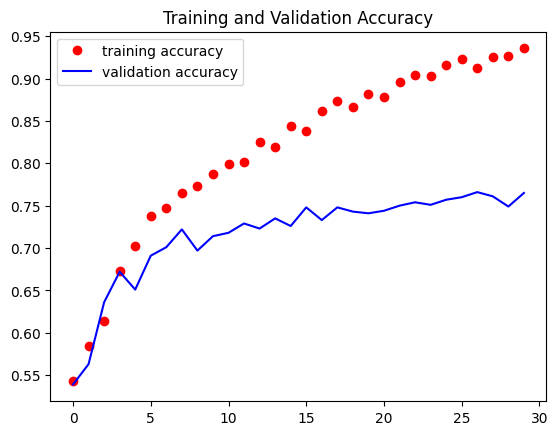

<ipython-input-14-d825deb58ac0>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(train_loss, 'bo', color='r', label='training loss')
<ipython-input-14-d825deb58ac0>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(val_loss, 'b', color='b', label='validation loss')


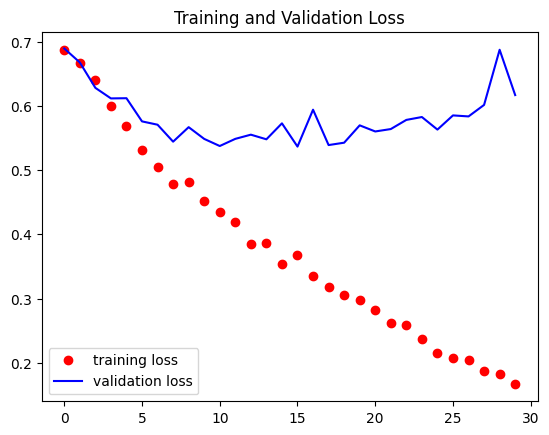

In [14]:
import matplotlib.pyplot as plt

train_acc = model_result.history['accuracy']
val_acc = model_result.history['val_accuracy']
train_loss = model_result.history['loss']
val_loss = model_result.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

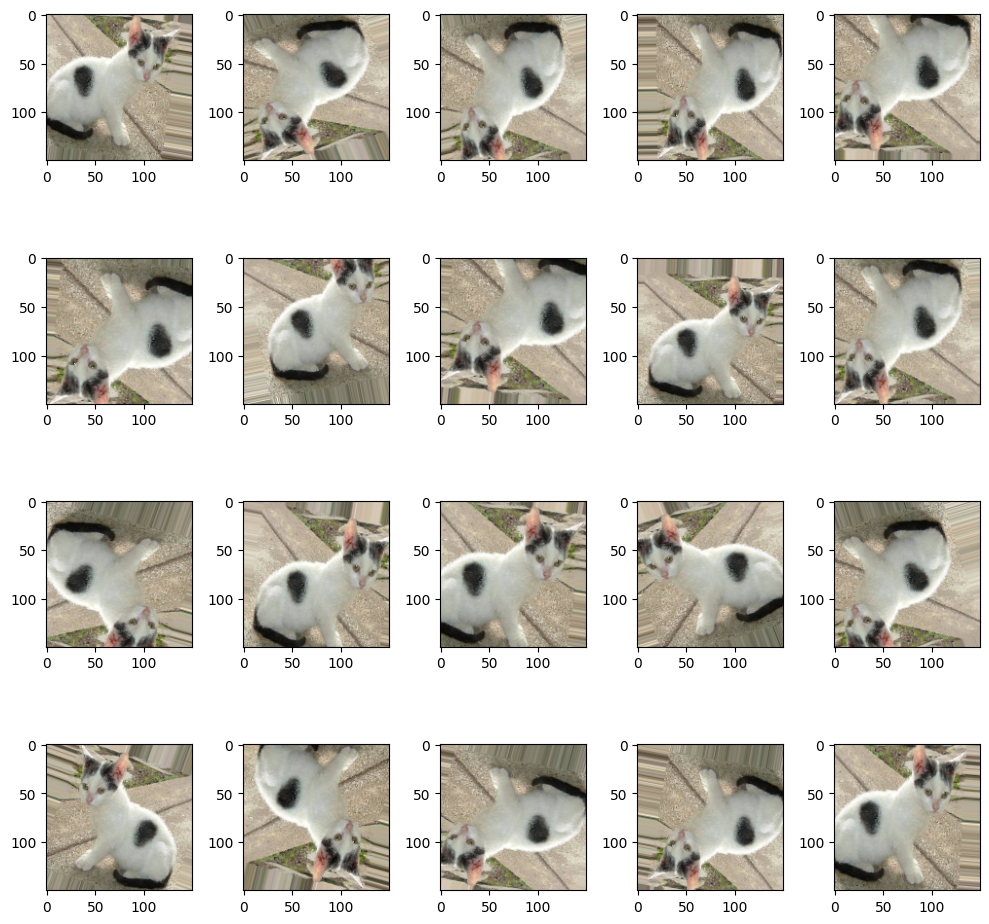

In [17]:
# ImageDataGenerator를 이용해서 이미지 증식

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

data_gen = ImageDataGenerator(rotation_range = 20,
                              width_shift_range = 0.1,    # width_shift_range : 가로방향 이동 # 0.1는 10% 의미
                              height_shift_range = 0.1,    # height_shift_range : 세로방향 이동
                              shear_range = 0.1,
                              zoom_range = 0.1,
                              horizontal_flip=True,       # 이렇게 할수도 있다는 의미
                              vertical_flip = True,
                              fill_mode = 'nearest'       # fill_mode : 빈 부분을 어떻게 채울 것인가?  # 가장 가까운 이미지로
                              )

img = image.load_img('/content/train/cats/cat.3.jpg',
                     target_size = (150, 150))

x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)    # (1, 150, 150, 3)

fig = plt.figure(figsize = (10, 10))
axs = []

for i in range(20):
  axs.append(fig.add_subplot(4, 5, i+1))

idx = 0

for batch in data_gen.flow(x, batch_size = 1):
  imgplot = axs[idx].imshow(image.array_to_img(batch[0]))
  idx += 1
  if idx % 20 == 0:
    break

fig.tight_layout()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(20, 150, 150, 3)
(20,)
Epoch 1/30
100/100 [==============================] - 19s 161ms/step - loss: 0.6926 - accuracy: 0.5170 - val_loss: 0.6897 - val_accuracy: 0.5840
Epoch 2/30
100/100 [==============================] - 16s 160ms/step - loss: 0.6881 - accuracy: 0.5435 - val_loss: 0.6883 - val_accuracy: 0.5220
Epoch 3/30
100/100 [==============================] - 16s 157ms/step - loss: 0.6822 - accuracy: 0.5545 - val_loss: 0.6751 - val_accuracy: 0.5240
Epoch 4/30
100/100 [==============================] - 16s 158ms/step - loss: 0.6679 - accuracy: 0.5865 - val_loss: 0.6601 - val_accuracy: 0.6030
Epoch 5/30
100/100 [==============================] - 16s 160ms/step - loss: 0.6477 - accuracy: 0.6290 - val_loss: 0.6261 - val_accuracy: 0.6530
Epoch 6/30
100/100 [==============================] - 16s 161ms/step - loss: 0.6260 - accuracy: 0.6415 - val_loss: 0.6007 - val_accuracy: 0.6680
Epoch 7/30
100/100 [==

<ipython-input-19-2c7bb3a6c6ec>:130: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(train_acc, 'bo', color='r', label='training accuracy')
<ipython-input-19-2c7bb3a6c6ec>:131: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(val_acc, 'b', color='b', label='validation accuracy')


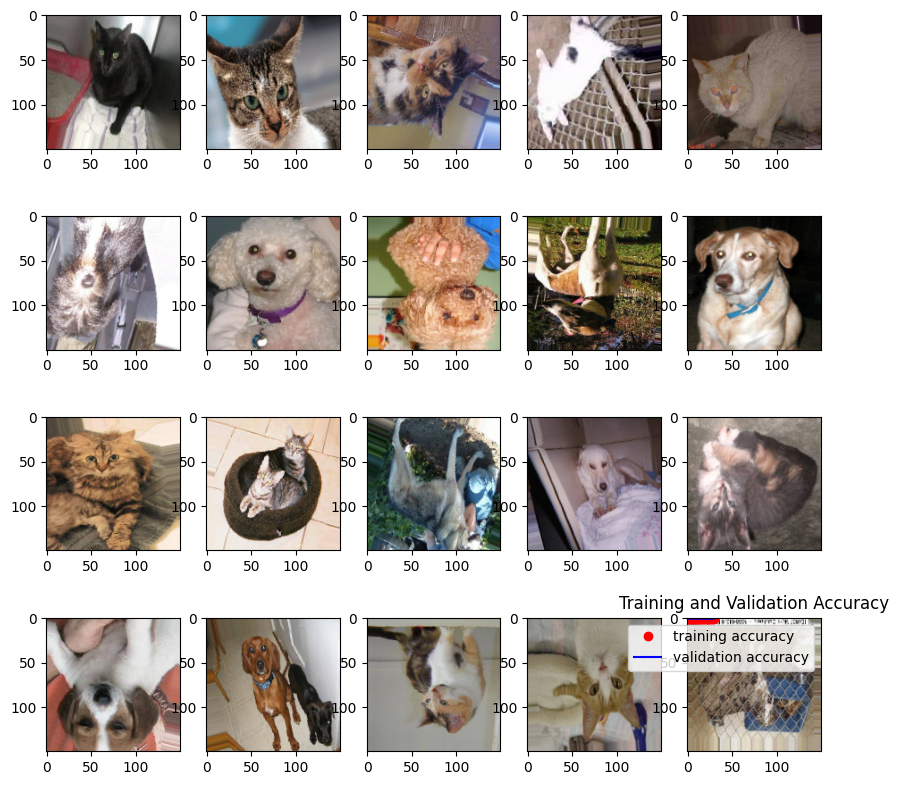

<ipython-input-19-2c7bb3a6c6ec>:136: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(train_loss, 'bo', color='r', label='training loss')
<ipython-input-19-2c7bb3a6c6ec>:137: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(val_loss, 'b', color='b', label='validation loss')


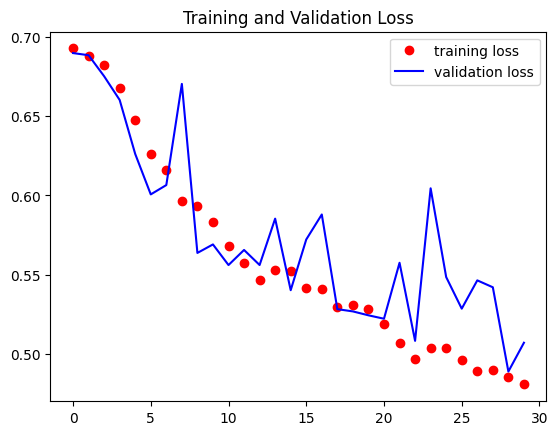

In [19]:
# 4000개의 이미지를 이용해서 Image Augmentation 기법을 적용한 ImageDataGenerator를 사용해서
# 증식된 데이터로 모델을 학습

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator 생성

# 모든 이미지 데이터값을 1/255로 scaling(MinMaxScaling)하는
# ImageDataGenerator 생성

train_data_generator = ImageDataGenerator(rescale = 1/255,
                                          rotation_range = 20,
                                          width_shift_range = 0.1,    # width_shift_range : 가로방향 이동 # 0.1는 10% 의미
                                          height_shift_range = 0.1,    # height_shift_range : 세로방향 이동
                                          shear_range = 0.1,
                                          zoom_range = 0.1,
                                          horizontal_flip=True,       # 이렇게 할수도 있다는 의미
                                          vertical_flip = True,
                                          fill_mode = 'nearest')
validation_data_generator = ImageDataGenerator(rescale = 1/255)

train_dir = '/content/train'
validation_dir = '/content/validation'

# 실제 데이터를 추출하는 generator 생성
train_generator = train_data_generator.flow_from_directory(
    train_dir, # target directory
    classes = ['cats', 'dogs'],  # cats, dogs 폴더 순서로 0,1로 target을 지정
    target_size = (150, 150), # image resize
    batch_size = 20,
    class_mode = 'binary' # 만약 다중분류일 경우라면 categorical
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir, # target directory
    classes = ['cats', 'dogs'],  # cats, dogs 폴더 순서로 0,1로 target을 지정
    target_size = (150, 150), # image resize
    batch_size = 20,
    class_mode = 'binary' # 만약 다중분류일 경우라면 categorical
)

# 이렇게 만든 generator가 정상적으로 동작하는지 확인
for x_data, t_data in train_generator:
    print(x_data.shape)
    print(t_data.shape)
    break

# 그림을 이용해서 추출한 데이터가 이미지 데이터인지 확인
fig = plt.figure(figsize = (10,10))
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4, 5, i+1))

for x_data, t_data in train_generator:

    for idx, img_data in enumerate(x_data): # (20, 150, 150, 3)
        axs[idx].imshow(img_data)
    break


# 위에서 생성한 ImageDataGenerator를 이용해서 keras model을 생성해서 학습
# CNN 구현
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()

# 1
model.add(Conv2D(filters = 32,
                kernel_size = (3,3),
                activation = 'relu',
                input_shape = (150, 150, 3)))

model.add(MaxPooling2D(pool_size = (2, 2)))
# 2
model.add(Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
# 3
model.add(Conv2D(filters = 128,
                kernel_size = (3,3),
                activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
# 4
model.add(Conv2D(filters = 128,
                kernel_size = (3,3),
                activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))  # 특성추출 끝

model.add(Flatten())

model.add(Dropout(rate = 0.5))

model.add(Dense(units = 256,
               activation = 'relu'))

model.add(Dense(units = 1,
               activation = 'sigmoid'))

model.compile(optimizer = Adam(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# train_generator는 한번에 이미지 데이터를 20장 뽑는다
# 그런데 1 epoch을 수행 하려면 14,000개 이미지 사용
# 따라서 1 epoch을 돌리기 위해 generator는 700번 수행
model_result = model.fit(train_generator,
                         steps_per_epoch = 100,
                         epochs = 30,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = 50)

import matplotlib.pyplot as plt

train_acc = model_result.history['accuracy']
val_acc = model_result.history['val_accuracy']
train_loss = model_result.history['loss']
val_loss = model_result.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()